In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.model_selection import train_test_split
import sklearn.metrics as skmetrics

import torch
import torchvision
import torchvision.transforms as transforms

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from torch.utils.data import Dataset, DataLoader
from torch.utils.data.sampler import SubsetRandomSampler,WeightedRandomSampler
import torchvision.models as models

from PIL import Image
import io
import pathlib

In [2]:
skip_training = False
device = torch.device('cuda:0')
image_information = pd.read_csv("data/HAM10000_metadata.csv")

In [3]:
image_information.head()

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp
1,HAM_0000118,ISIC_0025030,bkl,histo,80.0,male,scalp
2,HAM_0002730,ISIC_0026769,bkl,histo,80.0,male,scalp
3,HAM_0002730,ISIC_0025661,bkl,histo,80.0,male,scalp
4,HAM_0001466,ISIC_0031633,bkl,histo,75.0,male,ear


Actinic keratoses and intraepithelial carcinoma / Bowen's disease (akiec),
basal cell carcinoma (bcc), 
benign keratosis-like lesions (solar lentigines / seborrheic keratoses and lichen-planus like keratoses, bkl),
dermatofibroma (df),
melanoma (mel), 
melanocytic nevi (nv)
vascular lesions (angiomas, angiokeratomas, pyogenic granulomas and hemorrhage, vasc).

In [4]:
image_information['dx'].value_counts()

nv       6705
mel      1113
bkl      1099
bcc       514
akiec     327
vasc      142
df        115
Name: dx, dtype: int64

In [5]:
#.astype('category') sorts alphabetically
classes = ['akiec','bcc','bkl','df','mel','nv','vasc']
#weights = [1/327,1/514, 1/1099, 1/115, 1/1113, 1/6705, 1/142]
#weights = [1,1,1/2,1,1/2,1/6,1]


In [9]:
y = image_information.dx
X_train, X_val, y_train, y_test = train_test_split(y,y, test_size=0.2, stratify=y)

images_train_info = image_information.loc[y_train.index].reset_index(drop=True)
images_test_info = image_information.loc[y_test.index].reset_index(drop=True)

#https://stackoverflow.com/questions/48373088/duplicating-training-examples-to-handle-class-imbalance-in-a-pandas-data-frame
#max_size = images_train_info['dx'].value_counts().max()

max_size = 2000
lst = [images_train_info]
for class_index, group in images_train_info.groupby('dx'):
    if len(group) < 2000:
        lst.append(group.sample(max_size-len(group), replace=True))
    
images_train_info = pd.concat(lst).reset_index(drop=True)

images_train_info['dx'].value_counts()

nv       5364
bkl      2000
akiec    2000
df       2000
vasc     2000
mel      2000
bcc      2000
Name: dx, dtype: int64

In [8]:
#image_information['dx'].nunique()
#categories = image_information['dx'].astype('category')
#torch.from_numpy(np.array(image_information['dx'].astype('category').cat.codes, dtype=np.uint8)).long()

In [13]:
#transforms.RandomRotation((1, 359))
transform_train = transforms.Compose([
    transforms.Resize((299,299)), #inception-v3 accepts tensors of size Nx3x299x299
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.1, contrast=0.1, hue=0.1),
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

transform_test = transforms.Compose([
    transforms.Resize((299,299)), #inception-v3 accepts tensors of size Nx3x299x299
    transforms.ToTensor(),  
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) 
])

In [14]:
#https://discuss.pytorch.org/t/custom-dataset-with-some-preprocessing/30385/2
#https://discuss.pytorch.org/t/problems-with-target-arrays-of-int-int32-types-in-loss-functions/140/2
#https://discuss.pytorch.org/t/cant-convert-np-ndarray-of-type-numpy-bool/32669
class HAMN10000DataSet(Dataset):

    def __init__(self, csv_path, img_dir, transform=None):
    
        df = csv_path#pd.read_csv(txt_path)
        self.img_dir = img_dir
        self.csv_path = csv_path
        self.img_names = df['image_id'] + '.jpg' #name image id
        self.y = torch.from_numpy(np.array(df['dx'].astype('category').cat.codes, dtype=np.uint8)).long()
        self.y_str = df['dx'].values #values
        self.transform = transform

    def __getitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        if self.transform is not None:
            img = self.transform(img)
        
        label = self.y[index]
        return img, label
    
    def __visualizeitem__(self, index):
        img = Image.open(os.path.join(self.img_dir,
                                      self.img_names[index]))
        
        label = self.y_str[index]
        return img, label

    def __len__(self):
        return self.y.shape[0]

In [15]:
dataset_train = HAMN10000DataSet(csv_path=images_train_info,
                              img_dir='data/images', transform=transform_train)

dataset_test = HAMN10000DataSet(csv_path=images_test_info,
                              img_dir='data/images', transform=transform_test)

In [16]:
#dd = 4215
#print(dataset_train.y[dd])
#print(dataset_train.y_str[dd])


In [17]:
dataset_train.y.shape

torch.Size([17364])

In [18]:
#train_sampler = WeightedRandomSampler(weights, num_samples=dataset_train.__len__(),replacement=True)

In [19]:
batchsize= 16

#trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, 
#                                           sampler=train_sampler)
#testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batchsize,
#                                                sampler=test_sampler)
trainloader = torch.utils.data.DataLoader(dataset_train, batch_size=batchsize, shuffle=True)
testloader = torch.utils.data.DataLoader(dataset_test, batch_size=batchsize, shuffle=False)

In [20]:
dataiter = iter(trainloader)
images, labels = dataiter.next()


In [21]:
images.shape

torch.Size([16, 3, 299, 299])

In [22]:
img, label = dataset_train.__getitem__(2110)

In [23]:
img.shape

torch.Size([3, 299, 299])

### Visualizing the dataset

bkl


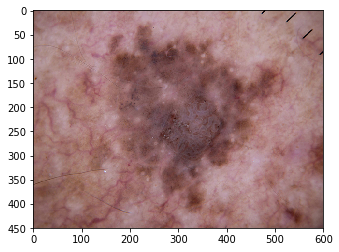

In [24]:
img, label = dataset_train.__visualizeitem__(1200)
plt.imshow(img)
print(label)

## Training CNN

### training Inception-v3

In [25]:
#https://discuss.pytorch.org/t/imagenet-example-with-inception-v3/1691/5
net = models.inception_v3()
net.AuxLogits.fc = nn.Linear(768, 7)
net.fc = nn.Linear(2048, 7) #inception-v3 output layer num_classes change from default 1000 to 7
net.to(device)

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(192, eps=0.001, momentum=0.1, affine=True, t

In [26]:
# Feed a batch of images from the training data to test the network
with torch.no_grad():
    dataiter = iter(trainloader)
    images, labels = dataiter.next()
    images = images.to(device)
    print('Shape of the input tensor:', images.shape)

    y = net(images)
    assert y[0].shape == torch.Size([16, 7]), "Bad shape of y: y.shape={}".format(y.shape)

print('The shapes seem to be ok.')

Shape of the input tensor: torch.Size([16, 3, 299, 299])
The shapes seem to be ok.


In [28]:
# Define the loss and the optimizer
criterion = nn.CrossEntropyLoss()#weight=weights
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [29]:
# This function computes the accuracy on the test dataset
def compute_accuracy(net, testloader):
    net.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

In [ ]:
n_epochs=10
accuracies = []

In [ ]:
# Let us train the network for 10 epochs (one epoch is one pass though the training data)
#https://discuss.pytorch.org/t/attributeerror-tuple-object-has-no-attribute-log-softmax/37309

for epoch in range(n_epochs):
    net.train() #set net to train mode again otherwise auxillary values fail
    running_loss = 0.0
    print_every = 100  # mini-batches
    for i, (inputs, labels) in enumerate(trainloader, 0):
        # Transfer to GPU
        inputs = inputs.to(device)
        labels = labels.to(device)

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs, aux_out = net(inputs) #inception model has auxillary output to handle vanishing gradient problem
        
        l1_loss = criterion(outputs, labels)
        l2_aux_loss = criterion(aux_out, labels)
        loss = l1_loss + 0.4* l2_aux_loss
        
        loss.backward()
        optimizer.step()

        # print statistics
        running_loss += loss.item()
        if (i % print_every) == (print_every-1):
            print('[%d, %5d] loss: %.3f' % (epoch+1, i+1, running_loss/print_every))
            running_loss = 0.0
        if skip_training:
            break

    accuracy = compute_accuracy(net, testloader)
    accuracies.append(accuracy)
    print('Accuracy of the network on the test images: %.3f' % accuracy)

print('Finished Training')

[1,   100] loss: 3.314
[1,   200] loss: 3.089


### Saved model

In [48]:
# Save the network to a file, submit this file together with your notebook
filename = 'inception_v3_skin_cancer.pth'
if not skip_training:
    try:
        do_save = input('Do you want to save the model (type yes to confirm)? ').lower()
        if do_save == 'yes':
            torch.save(net.state_dict(), filename)
            print('Model saved to %s' % filename)
        else:
            print('Model not saved')
    except:
        raise Exception('The notebook should be run or validated with skip_training=True.')
else:
    net = Net()
    net.load_state_dict(torch.load(filename, map_location=lambda storage, loc: storage))
    net.to(device)
    print('Model loaded from %s' % filename)

Do you want to save the model (type yes to confirm)? yes
Model saved to inception_v3_skin_cancer.pth


### Visualizing the model

In [27]:
# Let us look at the confusion matrix computed for the test set
def confusion_matrix(net, testloader):
    net.eval()
    true_labels = []
    predictions = []
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            predicted = torch.argmax(outputs.data, 1)
            true_labels.append(labels.cpu().numpy())
            predictions.append(predicted.cpu().numpy())
    true_labels = np.hstack(true_labels)
    predictions = np.hstack(predictions)

    return skmetrics.confusion_matrix(true_labels, predictions)

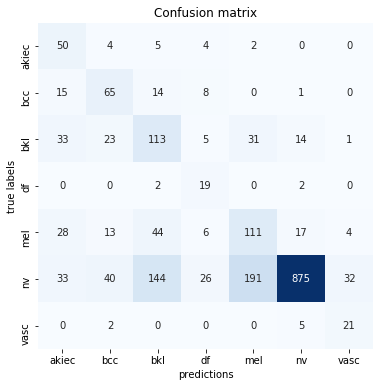

In [28]:
c_matrix = confusion_matrix(net, testloader)
plt.figure(figsize=(6, 6))
plt.title("Confusion matrix")
sns.heatmap(c_matrix, cmap='Blues', annot=True, xticklabels=classes, yticklabels=classes, fmt='g', cbar=False)
plt.xlabel('predictions')
plt.ylabel('true labels')

In [ ]:
#img = Image.open(r'data/images/ISIC_0027419')
#img = Image.open(open("/data/images/ISIC_0027419", 'rb'))
img = Image.open('data/images/ISIC_0027419.jpg')

In [ ]:
#img = Image.open(r'data/images/ISIC_0027419')